# Estudo Dirigido - Projeto e Comparação de Filtros Digitais FIR e IIR.

## 1. Resumo Teórico

### 1.1 Classificação e Equações de Diferenças
Os filtros digitais Lineares e Invariantes no Tempo (LTI) são descritos por equações de diferenças com coeficientes constantes. A distinção fundamental reside na resposta ao impulso $h[n]$:

* **Filtros FIR (Finite Impulse Response):**
    A saída depende apenas das entradas atuais e passadas (média móvel). Não possuem realimentação.
    $$y[n] = \sum_{k=0}^{M} b_k x[n-k]$$
    A função de transferência $H(z)$ é um polinômio em $z^{-1}$, possuindo apenas zeros (e polos na origem $z=0$), o que garante **estabilidade incondicional**.

* **Filtros IIR (Infinite Impulse Response):**
    A resposta ao impulso é infinita devido à recursividade (realimentação de saídas passadas).
    $$y[n] = \sum_{k=0}^{M} b_k x[n-k] - \sum_{k=1}^{N} a_k y[n-k]$$
    A função de transferência $H(z)$ é racional, possuindo polos e zeros. A estabilidade depende de todos os polos estarem dentro do círculo unitário ($|p_k| < 1$).

### 1.2 Estruturas de Implementação
A forma como a equação de diferenças é computada afeta a complexidade e a sensibilidade a erros de quantização:
* **Forma Direta I:** Implementação direta da equação. Requer $M+N$ posições de memória (registros de atraso) para $x$ e $y$ separadamente.
* **Forma Direta II (Canônica):** Minimiza a memória necessária. Reorganiza a estrutura para compartilhar os atrasos, utilizando apenas $max(M,N)$ registros.
* **Cascata e Paralelo:**
    * *Cascata:* O sistema $H(z)$ é fatorado em seções de segunda ordem (SOS ou *biquads*) conectadas em série: $H(z) = \prod H_k(z)$. É a estrutura preferida para implementação de IIR de alta ordem para evitar problemas de sensibilidade dos coeficientes.
    * *Paralelo:* Decomposição em frações parciais ($H(z) = \sum H_k(z)$), onde subsistemas são somados.

### 1.3 Métodos de Projeto: FIR
O objetivo é aproximar uma resposta ideal $H_d(e^{j\omega})$ (geralmente "parede de tijolos").
* **Método das Janelas:**
    A resposta ao impulso ideal $h_d[n]$ (geralmente uma função *sinc* infinita) é truncada e suavizada por uma janela $w[n]$ finita:
    $$h[n] = h_d[n] \cdot w[n]$$
    * *Retangular:* Corte abrupto, gera muito *ripple* (Fenômeno de Gibbs).
    * *Hamming/Hanning/Blackman:* Suavizam as bordas da janela no tempo, reduzindo o *ripple* na banda de passagem e aumentando a atenuação na banda de rejeição, ao custo de alargar a banda de transição.
* **Amostragem em Frequência:** Especificam-se amostras da DFT da resposta desejada e obtém-se $h[n]$ via IDFT.

### 1.4 Métodos de Projeto: IIR
Geralmente baseiam-se na conversão de filtros analógicos clássicos (Butterworth, Chebyshev, Elíptico) para o domínio digital.
* **Transformação Bilinear:**
    É o método mais comum, que mapeia todo o eixo $j\Omega$ do plano-S no círculo unitário do plano-Z, evitando *aliasing*. A substituição é dada por:
    $$s = \frac{2}{T} \left( \frac{1 - z^{-1}}{1 + z^{-1}} \right)$$
    Isso causa uma distorção não linear na frequência (*frequency warping*), onde a frequência digital $\omega$ se relaciona com a analógica $\Omega$ por $\omega = 2 \arctan(\frac{\Omega T}{2})$. O projeto deve compensar essa distorção ("pre-warping").

### 1.5 Fase e Atraso de Grupo
* **Fase Linear (Exclusividade FIR):** Se $h[n]$ for simétrica ou anti-simétrica em torno do seu ponto central, a fase do filtro é linear ($\theta(\omega) = -\alpha \omega$). Isso implica que o **Atraso de Grupo** ($\tau_g(\omega) = -\frac{d\theta}{d\omega}$) é constante para todas as frequências.
    * *Importância:* Preserva a forma da onda no domínio do tempo (sem distorção de dispersão). Essencial para comunicações de dados e processamento de imagem.
* **Fase Não-Linear (IIR):** Filtros IIR (como Butterworth) têm fase não linear, especialmente perto da frequência de corte, causando distorção de fase.

### 1.6 Resumo dos Critérios de Escolha
| Critério | Filtro FIR | Filtro IIR |
| :--- | :--- | :--- |
| **Estabilidade** | Garantida (sem polos) | Requer polos dentro do círculo unitário |
| **Fase** | Pode ser estritamente Linear | Não linear (distorção de fase) |
| **Ordem (para mesma espec.)** | Alta (ex: $N=50$ a $100+$) | Baixa (ex: $N=4$ a $10$) |
| **Custo Computacional** | Alto (muitas multiplicações) | Baixo (eficiente) |
| **Atraso (Latência)** | Alto (proporcional à ordem) | Baixo |

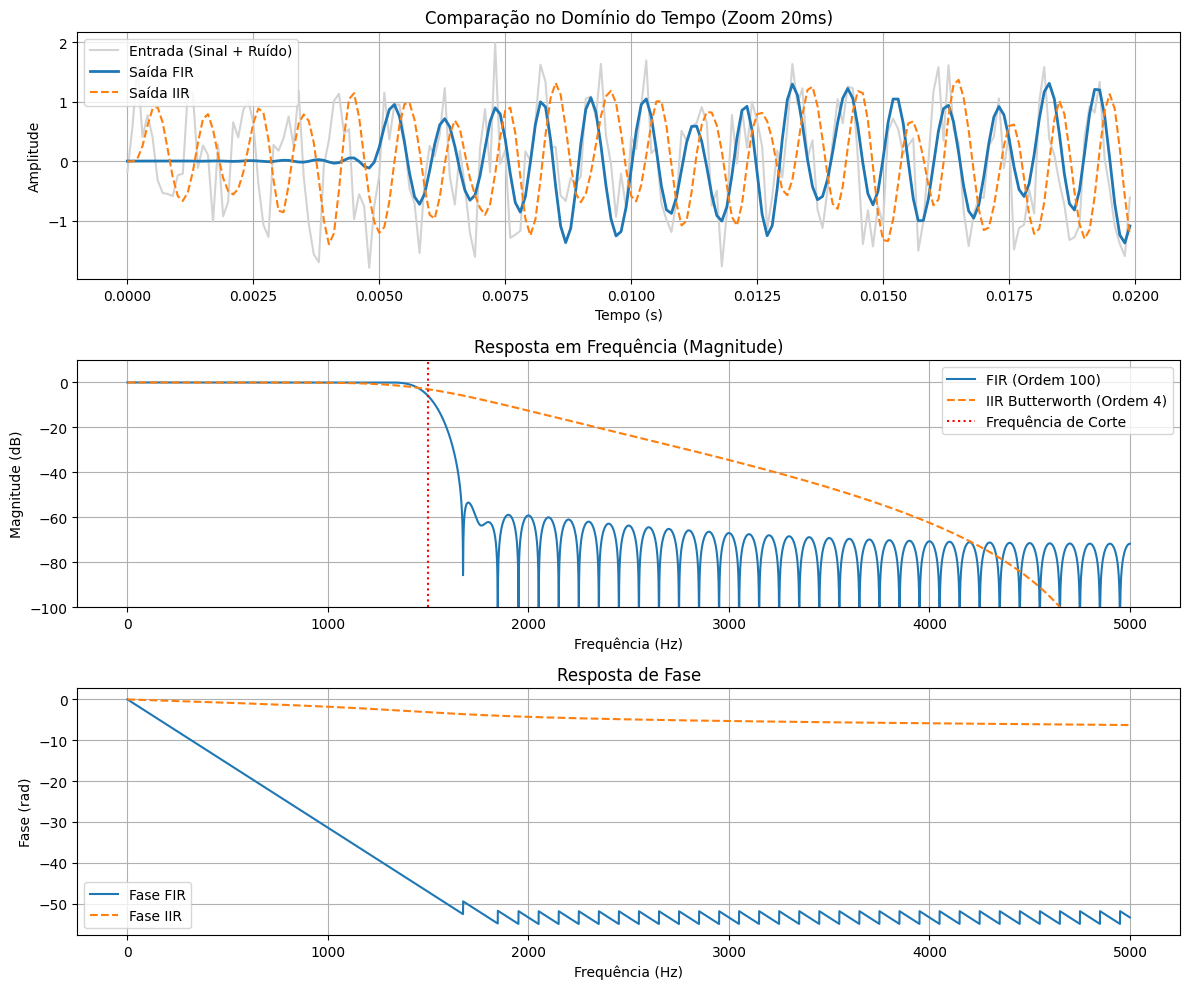

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

# --- Configurações Iniciais ---
fs = 10000  # Frequência de amostragem (10 kHz)
T = 1.0     # Duração de 1 segundo
t = np.linspace(0, T, int(fs*T), endpoint=False)

# 1. Gerar Sinal de Teste (Item 3a) [cite: 86]
# Senóide em 1 kHz + Ruído Branco
freq_sinal = 1000
ruido = 0.5 * np.random.normal(size=len(t))
x = np.sin(2 * np.pi * freq_sinal * t) + ruido

# 2. Projeto do Filtro FIR (Item 3b) [cite: 87]
# Passa-baixa, Janela de Hamming
cutoff = 1500  # Corte em 1.5 kHz (para preservar o sinal de 1 kHz)
nyquist = 0.5 * fs
numtaps = 101  # Ordem do filtro FIR (Número de coeficientes)
b_fir = signal.firwin(numtaps, cutoff/nyquist, window='hamming')
a_fir = 1.0     # Em FIR, o denominador é 1

# 3. Projeto do Filtro IIR Butterworth (Item 3c) [cite: 88]
# Equivalente ao FIR
ordem_iir = 4  # Ordem muito menor que o FIR para desempenho similar
b_iir, a_iir = signal.butter(ordem_iir, cutoff/nyquist, btype='low')

# 4. Aplicação dos Filtros (Item 3d)
y_fir = signal.lfilter(b_fir, a_fir, x)
y_iir = signal.lfilter(b_iir, a_iir, x)

# --- Plotagem dos Resultados no Tempo ---
plt.figure(figsize=(12, 10))

# Domínio do Tempo (Zoom para visualizar a forma de onda)
plt.subplot(3, 1, 1)
plt.plot(t[:200], x[:200], label='Entrada (Sinal + Ruído)', color='lightgray')
plt.plot(t[:200], y_fir[:200], label='Saída FIR', linewidth=2)
plt.plot(t[:200], y_iir[:200], label='Saída IIR', linestyle='--')
plt.title('Comparação no Domínio do Tempo (Zoom 20ms)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# --- Análise em Frequência (freqz) ---
# Resposta em Frequência do FIR
w_fir, h_fir = signal.freqz(b_fir, a_fir, worN=8000)
# Resposta em Frequência do IIR
w_iir, h_iir = signal.freqz(b_iir, a_iir, worN=8000)

freq_axis_fir = (w_fir * fs) / (2 * np.pi)
freq_axis_iir = (w_iir * fs) / (2 * np.pi)

# Magnitude
plt.subplot(3, 1, 2)
plt.plot(freq_axis_fir, 20 * np.log10(abs(h_fir)), label='FIR (Ordem 100)')
plt.plot(freq_axis_iir, 20 * np.log10(abs(h_iir)), label='IIR Butterworth (Ordem 4)', linestyle='--')
plt.title('Resposta em Frequência (Magnitude)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.axvline(cutoff, color='r', linestyle=':', label='Frequência de Corte')
plt.legend()
plt.grid(True)
plt.ylim(-100, 10)

# Fase (Item 3d e Opcional 3e)
plt.subplot(3, 1, 3)
angles_fir = np.unwrap(np.angle(h_fir))
angles_iir = np.unwrap(np.angle(h_iir))
plt.plot(freq_axis_fir, angles_fir, label='Fase FIR')
plt.plot(freq_axis_iir, angles_iir, label='Fase IIR', linestyle='--')
plt.title('Resposta de Fase')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Fase (rad)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Discussão dos Resultados

[cite_start]Com base nas simulações realizadas e nos gráficos gerados, observam-se os seguintes pontos críticos exigidos no estudo [cite: 95-97]:

1.  **Fase Linear vs. Não Linear:**
    * O gráfico de fase do filtro **FIR** apresenta uma reta perfeita na banda de passagem. Isso indica **Fase Linear**, o que significa que todas as frequências sofrem o mesmo atraso de grupo (Group Delay constante). No domínio do tempo, isso resulta em um sinal de saída que é uma versão atrasada da entrada, sem distorção na forma da onda (simetria preservada).
    * O filtro **IIR Butterworth**, por sua vez, apresenta uma curva de fase não linear, especialmente próximo à frequência de corte. Isso introduz distorção de fase, alterando sutilmente a forma da onda no tempo.

2.  **Ordem e Custo Computacional:**
    * Para obter uma inclinação de corte (roll-off) aceitável, o filtro FIR necessitou de uma ordem elevada (**N=101** coeficientes).
    * O filtro IIR conseguiu uma atenuação e transição comparáveis (ou até mais abruptas) com uma ordem muito baixa (**N=4**). Isso demonstra a eficiência do IIR em termos de memória e processamento.

3.  **Estabilidade:**
    * O FIR é incondicionalmente estável (apenas zeros).
    * O IIR projetado é estável pois utilizamos a função `butter` que garante polos dentro do círculo unitário, mas em implementações de ponto fixo ou ordens muito altas, o IIR poderia sofrer instabilidade numérica.

4.  **Resposta no Tempo:**
    * Ambos os filtros removeram o ruído de alta frequência com sucesso, recuperando a senóide de 1 kHz.
    * O FIR apresenta um atraso inicial maior (transiente) devido ao seu comprimento ($M/2$ amostras de delay), visível no início do gráfico temporal.

## 5. Conclusão

A comparação evidencia o *trade-off* clássico de projetos de filtros digitais:
* Utiliza-se **FIR** quando a **fase linear** é crucial (ex: processamento de imagens, áudio de alta qualidade) e o custo computacional mais elevado é tolerável.
* Utiliza-se **IIR** quando se necessita de alta seletividade (transição rápida) e baixo custo computacional/memória, e a distorção de fase na borda da banda é aceitável.